In [1]:
# Perform Regression against popularity for Remake and non-Remakes 
# and compare the predictions

In [2]:
# Import all necessary libs

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
sb.set()

#Set format for float to be $ because selected columns are currency
pd.options.display.float_format = '{:,.2f}'.format


In [3]:
## import excel into dataframe

mdata = pd.read_excel('MovieDataset.xlsx')
#mdata['budget_adj'] = pd.Series(["${0:.2f}".format(val) for val in mdata['budget_adj']])
#mdata['revenue_adj'] = pd.Series(["${0:.2f}".format(val) for val in mdata['revenue_adj']])
mdata['is_remake'] = mdata['is_remake'].str.upper() # format categorical value into upper case
mdata.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,is_remake,inflation_rate,year_difference
0,23437,tt1179056,1.07,35000000,115664037,A Nightmare on Elm Street,Jackie Earle Haley|Katie Cassidy|Kyle Gallner|...,http://www.nightmareonelmstreet.com/,Samuel Bayer,Never Sleep Again.,...,New Line Cinema|Platinum Dunes,4/30/10,423,5.50,2010,"35,000,000.00","115,664,037.00",Y,nan,nan
1,377,tt0087800,1.33,1800000,25504513,A Nightmare on Elm Street,John Saxon|Ronee Blakley|Heather Langenkamp|Am...,NaN,Wes Craven,"If Nancy Doesn't Wake Up Screaming, She Won't ...",...,New Line Cinema|Smart Egg Pictures,11/15/84,625,7.10,1984,"3,778,275.67","53,535,044.98",Y,nan,nan
2,1965,tt0120787,1.04,60000000,128038368,A Perfect Murder,Michael Douglas|Gwyneth Paltrow|Viggo Mortense...,NaN,Andrew Davis,A powerful husband. An unfaithful wife. A jeal...,...,Kopelson Entertainment|Warner Bros.,6/4/98,158,6.30,1998,"80,261,728.14","171,276,344.74",Y,nan,34.00
3,14644,tt0423877,0.09,0,0,Boudu,GÃ©rard Depardieu|Catherine Frot|GÃ©rard Jugno...,NaN,GÃ©rard Jugnot,NaN,...,Novo Arturo Films|DD Productions|TF1 Films Pro...,3/9/05,14,5.00,2005,0.00,0.00,Y,nan,19.00
4,1058,tt0085276,0.66,0,19910002,Breathless,Richard Gere|ValÃ©rie Kaprisky|Art Metrano|Joh...,NaN,Jim McBride,He's the last man on earth any woman needs - b...,...,Orion Pictures|Breathless Associates|Miko Prod...,5/13/83,32,5.80,1983,0.00,"43,589,206.25",Y,nan,23.00


In [4]:
# filter to selection columns only to avoid noises from other columns

cols = ['popularity', 'original_title', 'release_year','budget_adj','revenue_adj', 'is_remake']
movie_cleaner_cols = mdata[cols]
movie_cleaner_cols.head()

,popularity,original_title,release_year,budget_adj,revenue_adj,is_remake
0,1.07,A Nightmare on Elm Street,2010,"35,000,000.00","115,664,037.00",Y
1,1.33,A Nightmare on Elm Street,1984,"3,778,275.67","53,535,044.98",Y
2,1.04,A Perfect Murder,1998,"80,261,728.14","171,276,344.74",Y
3,0.09,Boudu,2005,0.00,0.00,Y
4,0.66,Breathless,1983,0.00,"43,589,206.25",Y


In [5]:
movie_cleaner_cols.dtypes

popularity        float64
original_title     object
release_year        int64
budget_adj        float64
revenue_adj       float64
is_remake          object
dtype: object

Ratio of the classes Y : N = 360 : 10506


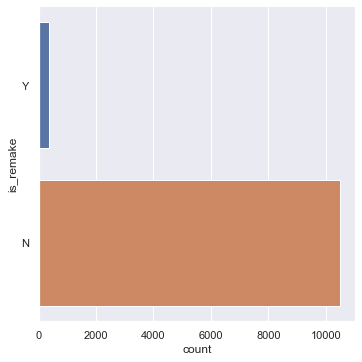

In [6]:
# Show amount of remakes and non remakes

is_remake = pd.DataFrame(movie_cleaner_cols['is_remake'])
distIR = is_remake["is_remake"].value_counts()
sb.catplot(y = "is_remake", data = is_remake, kind = "count")
print(f"Ratio of the classes Y : N = {distIR.loc['Y']} : {distIR.loc['N']}")

In [7]:
# extract data for prediction FOr remakes

remakes = movie_cleaner_cols[movie_cleaner_cols['is_remake'].str.match('Y')]  
remakes

,popularity,original_title,release_year,budget_adj,revenue_adj,is_remake
0,1.07,A Nightmare on Elm Street,2010,"35,000,000.00","115,664,037.00",Y
1,1.33,A Nightmare on Elm Street,1984,"3,778,275.67","53,535,044.98",Y
2,1.04,A Perfect Murder,1998,"80,261,728.14","171,276,344.74",Y
3,0.09,Boudu,2005,0.00,0.00,Y
4,0.66,Breathless,1983,0.00,"43,589,206.25",Y
...,...,...,...,...,...,...
355,1.35,The Sisterhood of the Traveling Pants,2005,"27,914,082.24","43,605,214.26",Y
356,0.45,The Sisterhood of the Traveling Pants 2,2008,"27,345,239.11","44,919,535.11",Y
357,0.10,The Skull,1965,0.00,0.00,Y
358,0.85,The Skulls,2000,"18,994,381.72","44,329,315.98",Y


In [8]:
# Prepare train and test data for remakes
popularity = pd.DataFrame(remakes['popularity'])  # Response
revenue_adj = pd.DataFrame(remakes['revenue_adj'])    

rev_train, rev_test, pop_train, pop_test = train_test_split(revenue_adj, popularity, test_size = 0.3)
print(f"Train Set : revenue_adj: {rev_train.shape}, is_remake: {pop_train.shape}")
print(f"Test Set : revenue_adj: {rev_test.shape} , is_remake: {pop_test.shape}")

Train Set : revenue_adj: (252, 1), is_remake: (252, 1)
Test Set : revenue_adj: (108, 1) , is_remake: (108, 1)


Intercept of Regression 	: b =  [95702888.4261319]
Coefficients of Regression 	: a =  [[79322637.75704587]]
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.32670158315314635
Mean Squared Error (MSE) 	: 9.25969979228492e+16



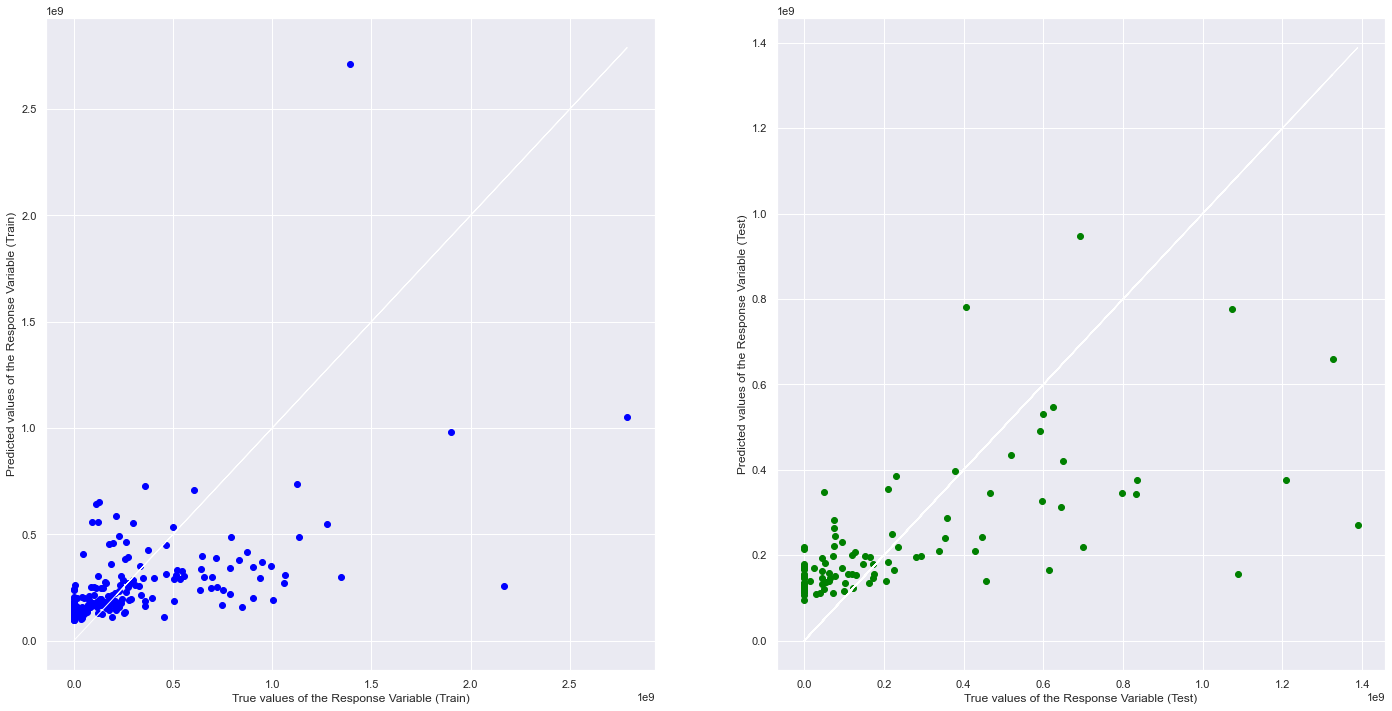

In [9]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(pop_train, rev_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)

rev_train_pred = linreg.predict(pop_train)
rev_test_pred = linreg.predict(pop_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(pop_train, rev_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(rev_train, rev_train_pred))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(rev_train, rev_train_pred, color = "blue")
axes[0].plot(rev_train, rev_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(rev_test, rev_test_pred, color = "green")
axes[1].plot(rev_test, rev_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [10]:
movie_pred = movie_cleaner_cols[movie_cleaner_cols["original_title"].isin(["Titanic", "Inception", "Cinderella"])]
movie_pred
predictors =  ["popularity"]
X_pred = pd.DataFrame(movie_pred[predictors])
y_pred = linreg.predict(X_pred)
y_pred = pd.DataFrame(y_pred, columns = ["pred_revenue"], index = movie_pred.index)
movie_predcheck = pd.concat([movie_pred[["original_title", "revenue_adj"]], y_pred], axis = 1)
movie_predcheck

,original_title,revenue_adj,pred_revenue
17,Cinderella,"498,963,025.22","536,484,349.72"
2219,Cinderella,0.00,"108,103,634.35"
4549,Inception,"825,500,000.00","838,451,750.20"
10051,Titanic,"2,506,405,735.42","441,170,347.52"
10052,Titanic,0.00,"113,103,419.54"


In [11]:
# extract data for prediction For non-remakes

nr = movie_cleaner_cols[movie_cleaner_cols['is_remake'].str.match('N')]  
nr

,popularity,original_title,release_year,budget_adj,revenue_adj,is_remake
360,0.36,...And Justice for All,1979,0.00,"100,051,648.28",N
361,1.22,'71,2014,0.00,"1,497,553.12",N
362,3.24,(500) Days of Summer,2009,"7,623,003.26","61,718,613.20",N
363,0.71,(T)Raumschiff Surprise - Periode 1,2004,0.00,0.00,N
364,0.68,*batteries not included,1987,0.00,"124,910,637.06",N
...,...,...,...,...,...,...
10861,0.53,Zoom,2006,"37,858,420.54","13,527,557.85",N
10862,0.19,Zorba the Greek,1964,"5,504,699.38",0.00,N
10863,0.93,Zulu,2013,"14,976,533.64",0.00,N
10864,0.31,Zulu,1964,0.00,0.00,N


In [12]:
# Prepare train and test data for remakes
popularity = pd.DataFrame(nr['popularity'])  # Response
revenue_adj = pd.DataFrame(nr['revenue_adj'])    

rev_train, rev_test, pop_train, pop_test = train_test_split(revenue_adj, popularity, test_size = 0.3)
print(f"Train Set : revenue_adj: {rev_train.shape}, is_remake: {pop_train.shape}")
print(f"Test Set : revenue_adj: {rev_test.shape} , is_remake: {pop_test.shape}")

Train Set : revenue_adj: (7354, 1), is_remake: (7354, 1)
Test Set : revenue_adj: (3152, 1) , is_remake: (3152, 1)


Intercept of Regression 	: b =  [-10548523.10641481]
Coefficients of Regression 	: a =  [[91992951.63400228]]
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.38515855202838734
Mean Squared Error (MSE) 	: 1.0233433369914338e+16



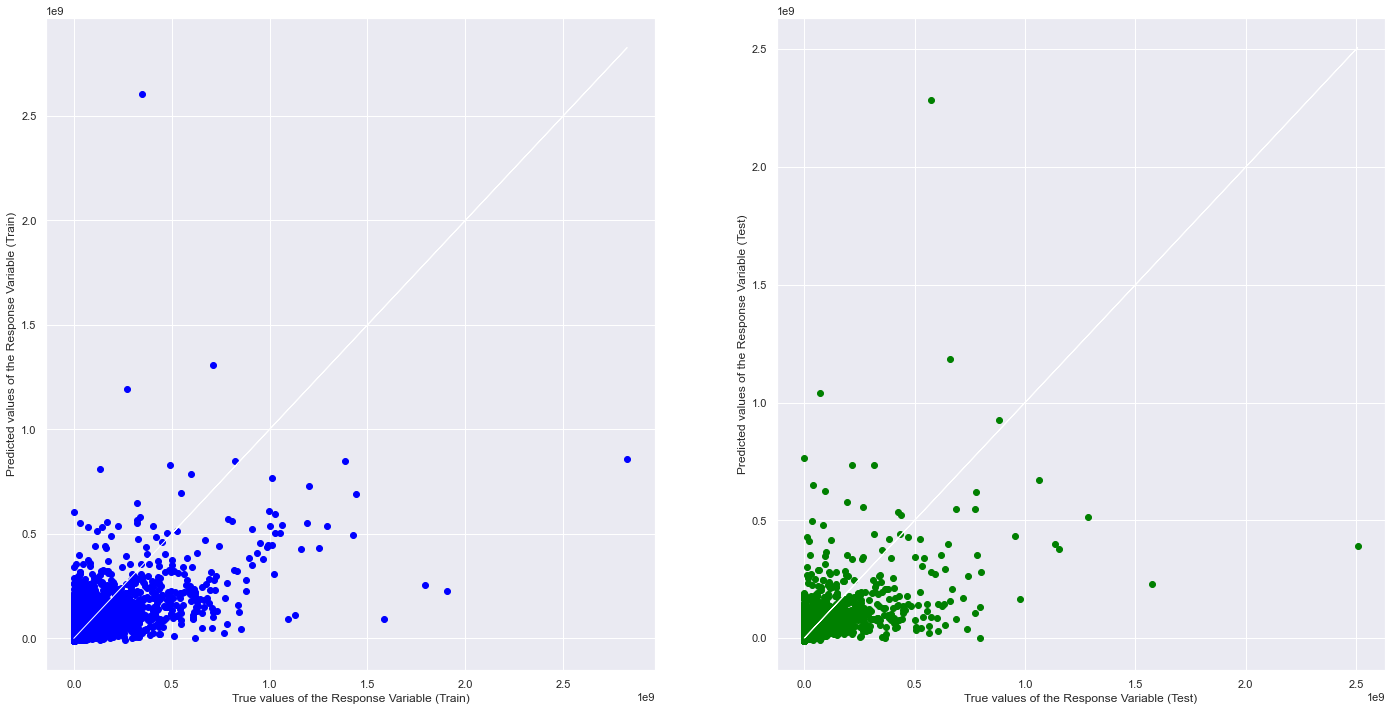

In [13]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(pop_train, rev_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)

rev_train_pred = linreg.predict(pop_train)
rev_test_pred = linreg.predict(pop_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(pop_train, rev_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(rev_train, rev_train_pred))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(rev_train, rev_train_pred, color = "blue")
axes[0].plot(rev_train, rev_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(rev_test, rev_test_pred, color = "green")
axes[1].plot(rev_test, rev_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [14]:
movie_pred = movie_cleaner_cols[movie_cleaner_cols["original_title"].isin(["Titanic", "Inception", "Cinderella"])]
movie_pred
predictors =  ["popularity"]
X_pred = pd.DataFrame(movie_pred[predictors])
y_pred = linreg.predict(X_pred)
y_pred = pd.DataFrame(y_pred, columns = ["pred_revenue"], index = movie_pred.index)
movie_predcheck = pd.concat([movie_pred[["original_title", "revenue_adj"]], y_pred], axis = 1)
movie_predcheck

,original_title,revenue_adj,pred_revenue
17,Cinderella,"498,963,025.22","500,639,566.41"
2219,Cinderella,0.00,"3,833,011.00"
4549,Inception,"825,500,000.00","850,840,634.51"
10051,Titanic,"2,506,405,735.42","390,100,927.72"
10052,Titanic,0.00,"9,631,418.74"
